In [126]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import optuna
from optuna.trial import TrialState

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm.notebook import trange

In [127]:
BATCH_SIZE = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

validset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
validloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [129]:
def define_model(trial):
    layers = []
    
    in_features = 3*32*32
    # We optimize the number of hidden units in the hidden layer
    out_features = trial.suggest_int("n_units", 128, 512)

    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.ReLU())

    layers.append(nn.Linear(out_features, len(classes)))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)

In [130]:
EPOCHS = 40
TRAIN_EXAMPLES_LIMIT = BATCH_SIZE * 40
VALID_EXAMPLES_LIMIT = BATCH_SIZE * 20

def objective(trial):

    # Generate the model.
    model = define_model(trial).to(device)

    # # We optimize the learning rate
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCH_SIZE >= TRAIN_EXAMPLES_LIMIT:
                break

            data, target = data.view(data.size(0), -1).to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(validloader):
                # Limiting validation data.
                if batch_idx * BATCH_SIZE >= VALID_EXAMPLES_LIMIT:
                    break
                data, target = data.view(data.size(0), -1).to(device), target.to(device)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(validloader.dataset), VALID_EXAMPLES_LIMIT)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [131]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-05-29 16:42:33,670] A new study created in memory with name: no-name-fd14d458-810b-446b-a7e1-f59eb3109a77
[I 2021-05-29 16:42:46,175] Trial 0 finished with value: 0.41796875 and parameters: {'n_units': 228, 'lr': 0.008823461952871115}. Best is trial 0 with value: 0.41796875.
[I 2021-05-29 16:42:58,621] Trial 1 finished with value: 0.16953125 and parameters: {'n_units': 310, 'lr': 2.303862410921136e-05}. Best is trial 0 with value: 0.41796875.
[I 2021-05-29 16:43:11,054] Trial 2 finished with value: 0.37734375 and parameters: {'n_units': 192, 'lr': 0.013630516495498275}. Best is trial 0 with value: 0.41796875.
[I 2021-05-29 16:43:23,559] Trial 3 finished with value: 0.41875 and parameters: {'n_units': 298, 'lr': 0.0037816640943820075}. Best is trial 3 with value: 0.41875.
[I 2021-05-29 16:43:36,040] Trial 4 finished with value: 0.371875 and parameters: {'n_units': 322, 'lr': 0.0009894047376253808}. Best is trial 3 with value: 0.41875.
[I 2021-05-29 16:43:36,666] Trial 5 pruned. 

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  91
  Number of complete trials:  9
Best trial:
  Value:  0.4328125
  Params: 
    n_units: 190
    lr: 0.004713903960705496


In [132]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim=3*32*32, hidden_dim=190, output_dim=10):
        super().__init__()
        self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim),
                nn.LogSoftmax(dim=1)
            )
    
    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        out = self.model(x_flat)
        return out

In [133]:
model = LogisticRegressionModel()
model = model.to(device)

lr = 0.004713903960705496
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

N_EPOCHS = 40
train_loss_hist = []
valid_loss_hist = []

for epoch in trange(N_EPOCHS):
    loss_list = []
    for imgs, labels in trainloader:
        
        #everything needs to be on the same device
        imgs, labels = imgs.to(device), labels.to(device)
        
        # forward pass
        pred_labels = model(imgs)
    
        # computing error
        loss = F.nll_loss(pred_labels, labels)
        loss_list.append(loss.item())

        # removing accumulated gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    train_loss_hist.append(np.mean(loss_list))
    
    loss_list = []
    with torch.no_grad():
        for imgs, labels in validloader:
            imgs, labels = imgs.to(device), labels.to(device)
            pred_labels = model(imgs)
            loss = F.nll_loss(pred_labels, labels)
            loss_list.append(loss.item())

    valid_loss_hist.append(np.mean(loss_list))

  0%|          | 0/40 [00:00<?, ?it/s]

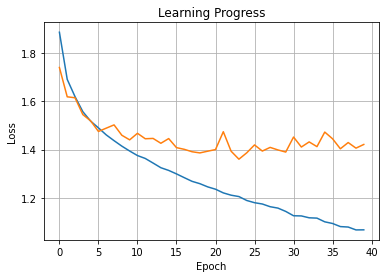

In [134]:
x = np.arange(len(train_loss_hist))
plt.plot(x, train_loss_hist)
plt.plot(x, valid_loss_hist)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Progress")
plt.show()

In [160]:
torch.save(model.state_dict(), './log_reg_cifar10.pth')

In [163]:
model = LogisticRegressionModel()
model.load_state_dict(torch.load('.//log_reg_cifar10.pth'))
model.to(device)

LogisticRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=190, bias=True)
    (1): ReLU()
    (2): Linear(in_features=190, out_features=10, bias=True)
    (3): LogSoftmax(dim=1)
  )
)

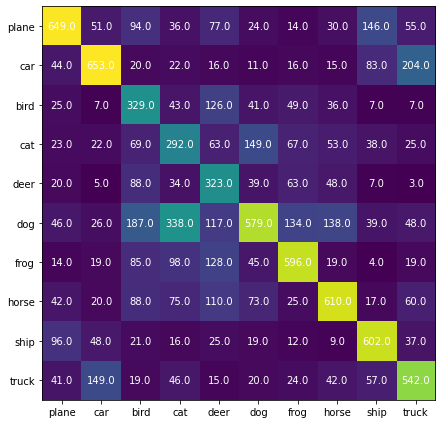

In [164]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

heat_map = np.zeros((10, 10))
with torch.no_grad():
    for imgs, labels in validloader:
        imgs, labels = imgs.to(device), labels.to(device)
        pred_labels = model(imgs)
        pred = pred_labels.argmax(dim=1)
        for i, j in zip(pred.tolist(), labels.tolist()):
            heat_map[i][j] += 1


fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(heat_map)


ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, heat_map[i][j], ha="center", va="center", color="w")

fig.tight_layout()
plt.show()